In [1]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==0.24.1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sklearn
print(sklearn.__version__) #should be 0.24.1

0.24.1


## DATA PREPROCESSING

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 
from random import shuffle

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [6]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
clients = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Contract df Preprocessing

In [7]:
display(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [8]:
contract.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date", "EndDate": "end_date",\
                         "Type":"type", "PaperlessBilling":"paperless_billing", "PaymentMethod":"paperless_billing",\
                        "PaymentMethod":"payment_method","MonthlyCharges":"monthly_charges","TotalCharges":"total_charges"},\
               inplace=True)

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customer_id          7043 non-null object
begin_date           7043 non-null object
end_date             7043 non-null object
type                 7043 non-null object
paperless_billing    7043 non-null object
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
#Checking for NaNs in contract.
print('contract NaNs:', contract.isna().sum().sum())
#Checking for duplicates in contract.
print('contract duplicates:', contract.duplicated().sum())

contract NaNs: 0
contract duplicates: 0


In [10]:
# Further information on contract df
print('The columns in the dataset contract.csv are:', contract.columns)
print('')
print('The types of the columns in the dataset contract.csv are:')
print(contract.dtypes)
print('')
print('The describe method of the dataset contract.csv is:')
print('')
print(contract.describe())

The columns in the dataset contract.csv are: Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

The types of the columns in the dataset contract.csv are:
customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
dtype: object

The describe method of the dataset contract.csv is:

       monthly_charges
count      7043.000000
mean         64.761692
std          30.090047
min          18.250000
25%          35.500000
50%          70.350000
75%          89.850000
max         118.750000


In [11]:
#Changing begin_date type.
contract.begin_date = pd.to_datetime(contract.begin_date)

In [12]:
#Transforming in total_charges column all the empty values (" ") to zeros.
contract.loc[contract.total_charges == " " , 'total_charges'] = 0.00

In [13]:
#Changing total_charges type to floating points.
contract.total_charges = pd.to_numeric(contract.total_charges, downcast='float')
contract.monthly_charges = contract.monthly_charges.astype('float64')
contract.total_charges = contract.total_charges.astype('float64').round(2)

In [14]:
print('total_charges mean', contract.total_charges.mean())
print('total_charges median', contract.total_charges.median())

total_charges mean 2279.7343035638223
total_charges median 1394.55


### Clients df Preprocessing

In [15]:
display(clients)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [16]:
clients.rename(columns={"customerID": "customer_id","SeniorCitizen":"senior_citizen", "Partner":"partner",\
                       "Dependents":"dependents"}, inplace=True)
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customer_id       7043 non-null object
gender            7043 non-null object
senior_citizen    7043 non-null int64
partner           7043 non-null object
dependents        7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [17]:
#Checking for NaNs in clients.
print('clients NaNs:', clients.isna().sum().sum())
#Checking for duplicates in clients.
print('clients duplicates:', clients.duplicated().sum())

clients NaNs: 0
clients duplicates: 0


In [18]:
#Analyzing gender column.
print(clients.gender.value_counts())
print()
print(clients.gender.value_counts(normalize=True))

Male      3555
Female    3488
Name: gender, dtype: int64

Male      0.504756
Female    0.495244
Name: gender, dtype: float64


In [19]:
#Analyzing senior_citizen column.
print(clients.senior_citizen.value_counts())
print()
print(clients.senior_citizen.value_counts(normalize=True))

0    5901
1    1142
Name: senior_citizen, dtype: int64

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


In [20]:
#Analyzing partner column.
print(clients.partner.value_counts())
print()
print(clients.partner.value_counts(normalize=True))

No     3641
Yes    3402
Name: partner, dtype: int64

No     0.516967
Yes    0.483033
Name: partner, dtype: float64


In [21]:
#Analyzing dependents column.
print(clients.dependents.value_counts())
print()
print(clients.dependents.value_counts(normalize=True))

No     4933
Yes    2110
Name: dependents, dtype: int64

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64


### Internet df preprocessing

In [22]:
display(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [23]:
internet.rename(columns={"customerID": "customer_id", "InternetService":"internet_service","OnlineSecurity":"online_security",\
                        "OnlineBackup":"online_backup","DeviceProtection":"device_protection","TechSupport":"tech_support",\
                        "StreamingTV":"streaming_tv","StreamingMovies":"streaming_movies"}, inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customer_id          5517 non-null object
internet_service     5517 non-null object
online_security      5517 non-null object
online_backup        5517 non-null object
device_protection    5517 non-null object
tech_support         5517 non-null object
streaming_tv         5517 non-null object
streaming_movies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
#Checking for NaNs in internet.
print('internet NaNs:', internet.isna().sum().sum())
#Checking for duplicates in internet.
print('internet duplicates:', internet.duplicated().sum())

internet NaNs: 0
internet duplicates: 0


In [25]:
#Analyzing internet_service column.
print(internet.internet_service.value_counts())
print()
print(internet.internet_service.value_counts(normalize=True))

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64


In [26]:
#Analyzing online_security column.
print(internet.online_security.value_counts())
print()
print(internet.online_security.value_counts(normalize=True))

No     3498
Yes    2019
Name: online_security, dtype: int64

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64


In [27]:
#Analyzing online_backup column.
print(internet.online_backup.value_counts())
print()
print(internet.online_backup.value_counts(normalize=True))

No     3088
Yes    2429
Name: online_backup, dtype: int64

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64


In [28]:
#Analyzing device_protection column.
print(internet.device_protection.value_counts())
print()
print(internet.device_protection.value_counts(normalize=True))

No     3095
Yes    2422
Name: device_protection, dtype: int64

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64


In [29]:
#Analyzing tech_support column.
print(internet.tech_support.value_counts())
print()
print(internet.tech_support.value_counts(normalize=True))

No     3473
Yes    2044
Name: tech_support, dtype: int64

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64


In [30]:
#Analyzing streaming_tv column.
print(internet.streaming_tv.value_counts())
print()
print(internet.streaming_tv.value_counts(normalize=True))

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

No     0.509335
Yes    0.490665
Name: streaming_tv, dtype: float64


In [31]:
#Analyzing streaming_movies column.
print(internet.streaming_movies.value_counts())
print()
print(internet.streaming_movies.value_counts(normalize=True))

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64


### Phone df preprocessing

In [32]:
display(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [33]:
phone.rename(columns={"customerID": "customer_id", "MultipleLines":"multiple_lines"}, inplace=True)

phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customer_id       6361 non-null object
multiple_lines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [34]:
#Checking for NaNs in phone.
print('phone NaNs:', phone.isna().sum().sum())
#Checking for duplicates in internet.
print('phone duplicates:', phone.duplicated().sum())

phone NaNs: 0
phone duplicates: 0


In [35]:
#Analyzing multiple_lines column.
print(phone.multiple_lines.value_counts())
print()
print(phone.multiple_lines.value_counts(normalize=True))

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64


### Target preprocessing

In [36]:
#Target analysis.
print(contract.end_date.value_counts())

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64


In [37]:
#Target analysis.
print(contract.end_date.value_counts(normalize=True))

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: end_date, dtype: float64


In [38]:
contract['target'] = np.where((contract['end_date'] != 'No'), 1, contract['end_date'])

In [39]:
contract['target'].replace('No', 0, inplace=True)
print(contract.target.value_counts())

0    5174
1    1869
Name: target, dtype: int64


In [40]:
contract['target'] = contract['target'].astype('int16')

### Creating new features

In [41]:
#Assigning 2020-02-01 00:00:00 where there's no in end_date column.
contract['end_date'] = np.where((contract['end_date'] == 'No'), '2020-02-01 00:00:00', contract['end_date'])

In [42]:
#Changing end_date type.
contract.end_date = pd.to_datetime(contract.end_date)

In [43]:
print(contract.end_date.value_counts())

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: end_date, dtype: int64


In [44]:
contract['days_with_company'] = contract.end_date - contract.begin_date

In [45]:
#obtaining integers from time_delta Series.
contract['days_with_company'] = (contract['days_with_company']).dt.days

## DATA VISUALIZATION

### Histograms

In [46]:
sns.set_style('darkgrid')

#### Monthly charge visualization

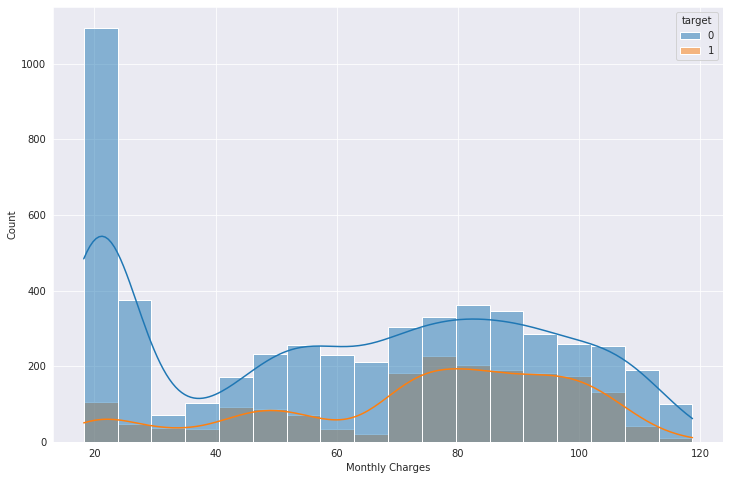

In [47]:
# Monthly Charges visualization.
plt.figure(figsize=(12,8))
sns.histplot(x='monthly_charges', data=contract, kde=True, hue='target')
plt.xlabel('Monthly Charges')
plt.show()

- Monthly charges histogram per target.

I wanted to visualize the values in the monthly charges column. I decided to do this visualization taking in account the model target. As we can see from the graph: there's is almost a normalized distribution for both category, except for the only abnormal peak from 20 to 30 for the people who doesn't churned the company. I expected something like because the majority of people with a phone/internet plan are just willing to pay the normal monthly bill price without requiring any kind of extras.

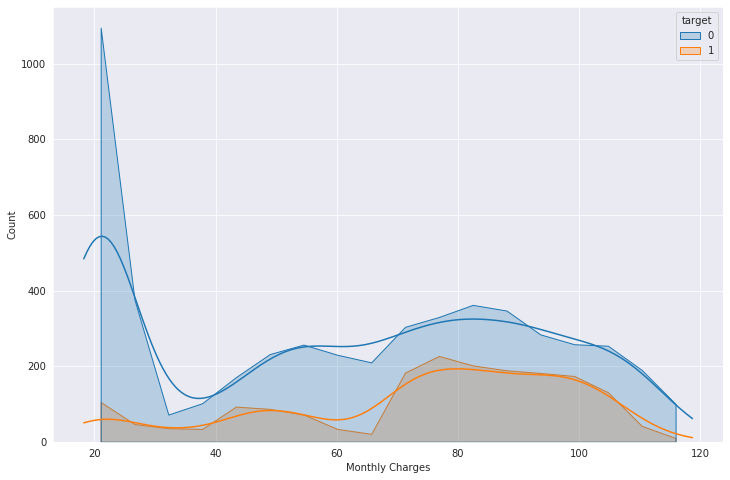

In [48]:
# Monthly Charges visualization.
plt.figure(figsize=(12,8))
sns.histplot(x='monthly_charges', data=contract, kde=True, hue='target', element='poly')
plt.xlabel('Monthly Charges')
plt.show()

- Monthly charges histogram per target. Polygonal.

I wanted to plot the same graph as before in polygonal form, the reason is that polygonal graph doesn't use bins and uses instead a regression line. This way we can get even a better understanding of the real values throughout the entire curve.

#### Total charges visualization

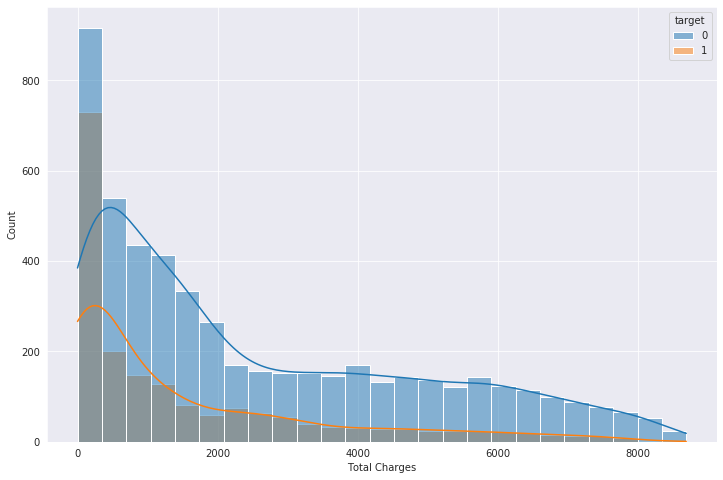

In [49]:
# Total Charges Visualization
plt.figure(figsize=(12,8))
sns.histplot(x='total_charges', data=contract, kde=True, hue='target')
plt.xlabel('Total Charges')
plt.show()

- Total charges visualization. Complete Histogram.

This time we analyze and take in consideration the total_charges column always for both targer. As expected the peak in the beginning is still there and our histogram is strongly right skewed. Having a really wide range, this histogram doesn't allow us to get a significant understanding of the values.

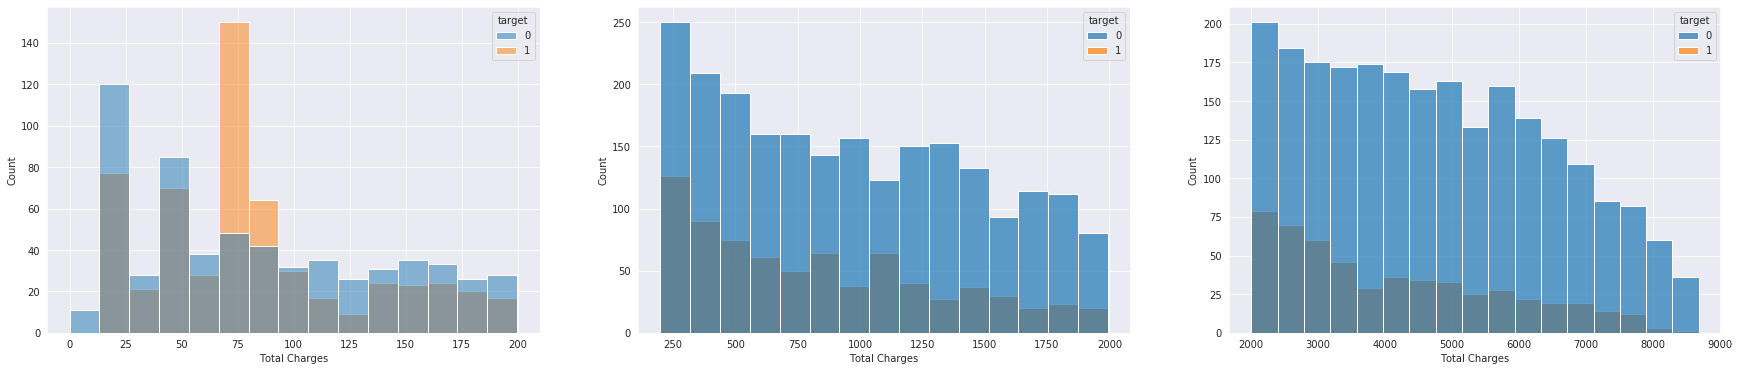

In [50]:
#Dividing the total_charges column in total_charges < 200, btw 200 and 2000 and > 2000 to get a better visualization of graphs.
total_charges_200 = contract.query('total_charges < 200')
total_charges_2000 = contract.query('total_charges > 200 and total_charges < 2000') 
total_charges_over = contract.query('total_charges > 2000')

plt.figure(figsize=(30,6)) # specifying figure size
ax1 = plt.subplot(1,3,1)
sns.histplot(data=total_charges_200, x='total_charges', ax = ax1, hue='target')
plt.xlabel('Total Charges')
ax2 = plt.subplot(1,3,2)
sns.histplot(data=total_charges_2000, x='total_charges', ax = ax2, hue='target', alpha=0.7)
plt.xlabel('Total Charges')
ax3 = plt.subplot(1,3,3)
sns.histplot(data=total_charges_over, x='total_charges', ax = ax3, hue='target', alpha=0.7)
plt.xlabel('Total Charges')
plt.show()

- Total charges visualization. Subplots (Ranges = [0:200], [200:2000], [2000:+])

I decided to divide the previous graph in three subplots, the range I took in consideration are:\
1)from 0 to 200\
2)from 200 to 2000\
3)fromm 2000 to 8684.8 (max value)

From those graphs we can see that the distribution for each graph is almost everywhere normalized even if still slightly right-skewed.

<span style="color:red">
The only anomalies detected is a really high peak for people who churned indentified among 70 and 80 in the first graph. A way to understand this anomalies in a better way, could be a further analysis on those people trying to understand the services they have benefited from, to understand possible reasorn for the churn. (Probably they thought that the quality/price of their services was too expansive).</span>

#### Days with company visualization.

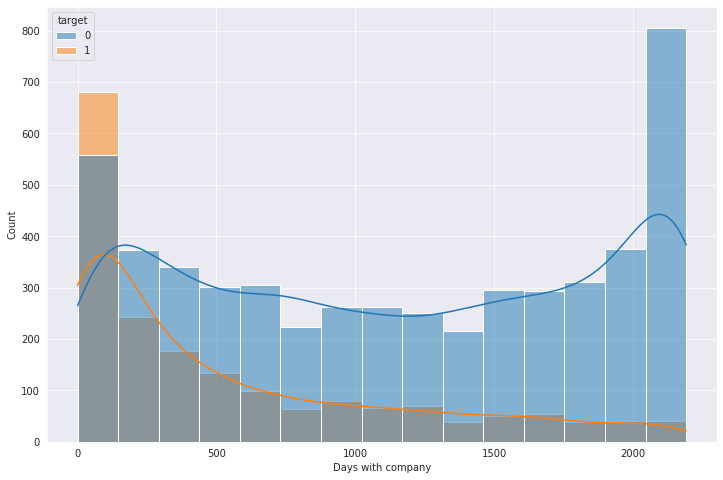

In [51]:
#Visualizing histograms of days_with_company column.
plt.figure(figsize=(12,8))
sns.histplot(x='days_with_company', data=contract, kde=True, hue='target')
plt.xlabel('Days with company')
plt.show()

- Days with company visualization. Histogram.

This graph shows how many days people stayed with the company highlightin people who left and who don't. My starting thoughts were confirmed from the graph people who left used to stay few time with the company, instead many people who doesn't churned are already loyal customers.

#### Target visualization

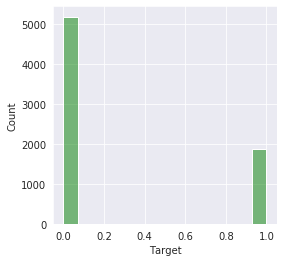


Target class imbalance:
0    0.73463
1    0.26537
Name: target, dtype: float64


In [52]:
#Visualizing our Target.
plt.figure(figsize=(4,4))
sns.histplot(x='target', data=contract, color='green', alpha=.5)
plt.xlabel('Target')
plt.show()
print()
print('Target class imbalance:')
print(contract.target.value_counts(normalize=True))

- Target visualization

In this graph we get a better understanding of our target and with the normalized value count of the column we get a good understanding of the class imbalance. The ratio we obtain is 3:1. Gonna upsample the target = 1.

### Boxplots

#### Monthly charges boxplots

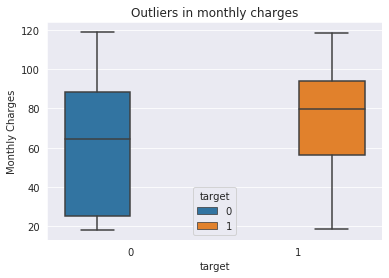

In [53]:
#target monthly_charges boxplot
sns.boxplot(x ='target', y='monthly_charges', data=contract, hue='target')
plt.ylabel('Monthly Charges')
plt.title('Outliers in monthly charges')
plt.show() 

- Monthly charges per target boxplot

In those boxplots we can appreciate the distribution of values and understand 25% quartile, median and 75% quartile of both categories. As we can easely see from the graph the people who churned were used to spend in median significantly more then who is still will our company. Probably there's a problem in our extra services. 

Outliers in monthly charges:  0


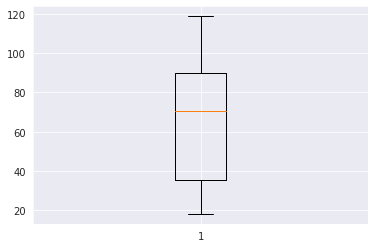

In [54]:
#monthly_charges boxplot.
monthly_boxplot = plt.boxplot(contract['monthly_charges'].values)
outliers = list(monthly_boxplot['fliers'][0].get_data()[1])
print('Outliers in monthly charges: ', len(outliers)) 

- Monthly charges boxplot

In this plot we see the entire monthly_charges column. And calculate the outliers within it. There're none. 

#### Total charges boxplots

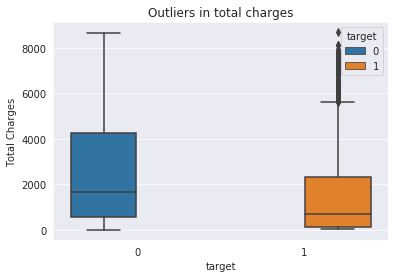

In [55]:
#target total_charges boxplot.
boxplot = sns.boxplot(x = 'target', y='total_charges', data=contract, hue='target')
plt.ylabel('Total Charges')
plt.title('Outliers in total charges')
plt.show() 

- Total charges per target boxplot.

In those boxplots we analyze total_charges column for both targets. This time the median is higher for people who doesn't left, this is a confirm of my thoughts, being more time with the company they tend to charge more on a long time period.

We can see that for target = 1 in this column, the upper whisker is set to almost 6000, for this reason whe find outliers in this plot. Being the upper whisker of 0 target on 8000, I don't expect to find outliers in the boxplot that contain both category.

Outliers in total charges:  0


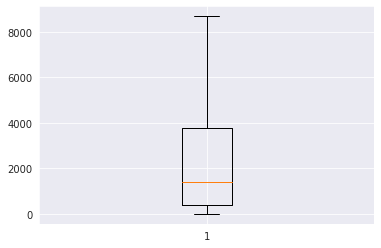

In [56]:
#total_charges boxplot
boxplot = plt.boxplot(contract['total_charges'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
print('Outliers in total charges: ', len(outliers)) 

- Total charges boxplot

Our toughts were confirmed, no outliers found the median is setted much more near the median of target 0 then 1.

## Merging dataframes and Encoding the features.

In [57]:
df = contract.merge(internet, on = 'customer_id', how='outer')
df = df.merge(phone, on = 'customer_id', how='outer')
df = df.merge(clients, on='customer_id', how='outer')

In [58]:
display(df)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days_with_company,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730,...,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191,...,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337,...,No,No,No,No,No,NaN,Female,0,Yes,Yes
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123,...,No,No,No,No,No,Yes,Male,1,Yes,No


In [59]:
#Creating has_phone feature.
df['has_phone'] = np.where((df['multiple_lines'] == 'No'), 1, np.nan)
df.loc[df['multiple_lines'] == 'Yes', 'has_phone'] = 1
df.has_phone = df['has_phone'].replace(np.nan, 0)
df.has_phone = df.has_phone.astype('int16')
print(df['has_phone'].value_counts(dropna=False))

1    6361
0     682
Name: has_phone, dtype: int64


In [60]:
#Creating has_internet feature.
df['has_internet'] = np.where((df['device_protection'] == 'No'), 1, np.nan)
df.loc[df['device_protection'] == 'Yes', 'has_internet'] = 1
df.has_internet = df['has_internet'].replace(np.nan, 0)
df.has_internet = df.has_internet.astype('int16')
print(df['has_internet'].value_counts(dropna=False))

1    5517
0    1526
Name: has_internet, dtype: int64


In [61]:
#Encoding the dataset
original = df
df = df.drop(['customer_id','begin_date','end_date','monthly_charges','total_charges','days_with_company'], axis=1)
df = df.astype(str).apply(LabelEncoder().fit_transform)

In [62]:
#Re-adding dropped columns.
df['begin_date'] = original['begin_date']
df['end_date'] = original['end_date']
df['monthly_charges'] = original['monthly_charges']
df['total_charges'] = original['total_charges']
df['days_with_company'] = original['days_with_company']

In [63]:
df = df.set_index(original['customer_id'])

In [64]:
display(df)
print(df.target.value_counts())

,type,paperless_billing,payment_method,target,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,...,senior_citizen,partner,dependents,has_phone,has_internet,begin_date,end_date,monthly_charges,total_charges,days_with_company
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,2,0,0,0,1,0,0,0,...,0,1,0,0,1,2020-01-01,2020-02-01,29.85,29.85,31
5575-GNVDE,1,0,3,0,0,1,0,1,0,0,...,0,0,0,1,1,2017-04-01,2020-02-01,56.95,1889.50,1036
3668-QPYBK,0,1,3,1,0,1,1,0,0,0,...,0,0,0,1,1,2019-10-01,2019-12-01,53.85,108.15,61
7795-CFOCW,1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,1,2016-05-01,2020-02-01,42.30,1840.75,1371
9237-HQITU,0,1,2,1,1,0,0,0,0,0,...,0,0,0,1,1,2019-09-01,2019-11-01,70.70,151.65,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,1,3,0,0,1,0,1,1,1,...,0,1,1,1,1,2018-02-01,2020-02-01,84.80,1990.50,730
2234-XADUH,1,1,1,0,1,0,1,1,0,1,...,0,1,1,1,1,2014-02-01,2020-02-01,103.20,7362.90,2191
4801-JZAZL,0,1,2,0,0,1,0,0,0,0,...,0,1,1,0,1,2019-03-01,2020-02-01,29.60,346.45,337


0    5174
1    1869
Name: target, dtype: int64


In [65]:
#Examinate the interested target column.
print('The number of non-exited customers is:', df.target.loc[df.target == 0].count())
print()
print('The number of exited customers is:', df.target.loc[df.target == 1].count())
print()
print('The percentage of non-exited customers is:', (len(df.target.loc[df.target == 0])/len(df.target)*100),'%')
print()
print('The percentage of exited customers is:', (len(df.target.loc[df.target == 1])/len(df.target)*100),'%')
print()

The number of non-exited customers is: 5174

The number of exited customers is: 1869

The percentage of non-exited customers is: 73.4630129206304 %

The percentage of exited customers is: 26.536987079369588 %



I merged the dataframes in one, getting as well columns for people who used internet and who used phone.

## Cross validation and model training

In [66]:
#Assigning features and target for the model construction.
features = df.drop(['begin_date','end_date', 'target'], axis=1)
target = df['target']

#Train test split.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=0)

In [67]:
#Balancing dataset. Upsampling to handle the imbalance.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + ([features_ones] * repeat))
    target_upsampled = pd.concat([target_zeros] + ([target_ones] * repeat))

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=0
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 3
)

features_upsampled.shape, (target_upsampled.shape)

((8094, 20), (8094,))

In [68]:
features_train.shape , target_train.shape

((5282, 20), (5282,))

In [69]:
target_test.value_counts()

0    1298
1     463
Name: target, dtype: int64

In [70]:
#Examinate the interested target column.
print('The number of non-exited customers is:', target_upsampled.loc[target_upsampled == 0].count())
print()
print('The number of exited customers is:', target_upsampled.loc[target_upsampled == 1].count())
print()
print('The percentage of non-exited customers is:', (len(target_upsampled.loc[target_upsampled == 0])/len(target_upsampled)*100),'%')
print()
print('The percentage of exited customers is:', (len(target_upsampled.loc[target_upsampled == 1])/len(target_upsampled)*100),'%')
print()

The number of non-exited customers is: 3876

The number of exited customers is: 4218

The percentage of non-exited customers is: 47.88732394366197 %

The percentage of exited customers is: 52.112676056338024 %



In [71]:
#Creating pipelines.
pipe_rfc = Pipeline([('scaler0', StandardScaler()),
                    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100))])

pipe_log_reg = Pipeline([('scaler1', StandardScaler()),
                       ('LogisticRegression(Dummy)', LogisticRegression(solver='lbfgs'))])

pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier())])

imba_pipeline = make_pipeline(SMOTE(random_state=0), RandomForestClassifier(n_estimators=100))

In [72]:
#Creating list of pipelines.
pipelines = [pipe_rfc, pipe_log_reg, pipe_lgbm]
#Creating a dictionary of pipelines.
pipe_dict = {pipe_rfc:'RandomForestClassifier', pipe_log_reg:'LogisticRegression', pipe_lgbm: 'LGBMClassifier'}

In [73]:
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring = 'roc_auc', cv=5))

RandomForestClassifier
[0.85746093 0.85826584 0.83107106 0.83477442 0.84902078]
LogisticRegression
[0.8594008  0.8506566  0.84013776 0.83262542 0.85816554]
LGBMClassifier
[0.89756072 0.88770533 0.87509126 0.87792217 0.87695557]


In [74]:
#Creating a parameters dictionary for LGBMRegressor possible hyperparameters values.
parameters = {'learning_rate': (0.09, 0.12, 0.1, 0.275),
              'n_estimators': (150, 110, 130, 70, 200), 
              } 

#Creating a grid model.
LGBM_grid = GridSearchCV(LGBMClassifier(), param_grid=parameters, scoring='roc_auc', cv=3) 
LGBM_grid_model = LGBM_grid.fit(features_train, target_train)
print(LGBM_grid_model.best_estimator_)
print(LGBM_grid_model.best_score_)

LGBMClassifier(n_estimators=200)
0.8829142052884024


In [75]:
features_train_smote, features_test_smote, target_train_smote, target_test_smote = train_test_split(features, target, test_size=0.25, random_state=0)

In [76]:
print('SMOTE RandomForestClassifier')
print(cross_val_score(imba_pipeline, features_train_smote, target_train_smote, scoring = 'roc_auc', cv=5))

SMOTE RandomForestClassifier
[0.85034808 0.84818348 0.82599931 0.82478016 0.84030307]


In [77]:
#Testing the models. - Upsampled model testing
pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier(learning_rate=0.125, n_estimators=150))])

pipe_lgbm.fit(features_train, target_train) 
predictions = pipe_lgbm.predict(features_test) 
        
print(f'Accuracy Test: {pipe_lgbm.score(features_test, target_test):.3f}')
print(f'Accuracy Train: {pipe_lgbm.score(features_train, target_train):.3f}')
print()
#auc_roc = roc_auc_score(target_test, predictions)
#print('ROC_AUC:', auc_roc)
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, pipe_lgbm.predict_proba(features_test)[:,1])
print('AUC:', auc(false_positive_rate, true_positive_rate))

Accuracy Test: 0.851
Accuracy Train: 0.964

AUC: 0.89183142698353


In [78]:
#Testing the models. - Upsampled model testing
pipe_cat =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', CatBoostClassifier(max_depth = 5, learning_rate=0.120, n_estimators=1500, \
                                                             verbose=500, random_state=0))])

pipe_cat.fit(features_train, target_train) 
predictions = pipe_cat.predict(features_test) 

print(f'Accuracy Test: {pipe_cat.score(features_test, target_test):.3f}')
print(f'Accuracy Train: {pipe_cat.score(features_train, target_train):.3f}')
print()

#auc_roc = roc_auc_score(target_test, predictions)
#print('ROC_AUC', auc_roc)
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, pipe_cat.predict_proba(features_test)[:,1])
print('AUC:', auc(false_positive_rate, true_positive_rate))

0:	learn: 0.6153191	total: 50.6ms	remaining: 1m 15s
500:	learn: 0.1669297	total: 8.78s	remaining: 17.5s
1000:	learn: 0.1034549	total: 23.2s	remaining: 11.6s
1499:	learn: 0.0710739	total: 38.6s	remaining: 0us
Accuracy Test: 0.872
Accuracy Train: 0.990

AUC: 0.9137891156688975


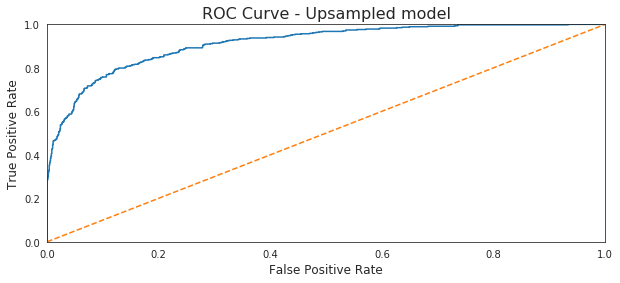

In [79]:
#ROC curve - Upsampled model.
probabilities = pipe_cat.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one) 

sns.set_style('white')
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Upsampled model', fontsize=16)
plt.show()

In [80]:
#Creating a confusion matrice upsampled model.
print('Confusion Matrice - Upsampled model.')
print()
cm = confusion_matrix(target_test, predictions)
print(cm)
print()
#Extracting TruePositive, FalsePositive, FalseNegative and TrueNegative from our confusion matrice.
tn, fn, fp, tp = confusion_matrix(target_test, predictions).ravel()
print('True positive:', tp)
print('False positive:', fp)
print('False negative:', fn)
print('True negative:', tn)
print()
exact = tp + tn
wrong = fp + fn
print('Exact results=',exact)
print('Wrong results=',wrong)

Confusion Matrice - Upsampled model.

[[1221   77]
 [ 148  315]]

True positive: 315
False positive: 148
False negative: 77
True negative: 1221

Exact results= 1536
Wrong results= 225


In [81]:
#Classification report. Upsampled model
report= classification_report(target_test, predictions)
print('Classification report - Upsampled model: \n', report)

Classification report - Upsampled model: 
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1298
           1       0.80      0.68      0.74       463

    accuracy                           0.87      1761
   macro avg       0.85      0.81      0.83      1761
weighted avg       0.87      0.87      0.87      1761



Defined features and targets, applied upsample on the training set. Obtaining this way an almost balanced target with :
- The percentage of non-exited customers is: 47.88732394366197 %
- The percentage of exited customers is: 52.112676056338024 %

Created basic pipelines for cross validation on training set. Decided to use LGBMClassifier.

With LGBMClassifier instance I was able to accomplish AUC_ROC: 89,18%
I decided to use a CatBoostClassifier, tuning it locally. I was able with this classifier to go even further obtaining a score of 91,37%. 

This score allow me to get above 0.88 and obtain 6SP, maximum provided. The model looks like is working in a good way and provides good results.

# Solution Report
- I tried to follow the schedule of main project, additional tasks and review. Trying to do my best to reach the fixed goals. I did my best facing every step with critical thinking, analyzing all the possible option in depth. I didn't skipped any step.
- I have done basically two mistake while developing this project: the first brought the data to leakage (it was about upsampling, I performed it on the entire dataset instead of doing that only on the trainig set), the second mistake was about metric calculation, solved quite soon with not that many difficulties. 
- During the preprocessing, after a meticulous analysis I decided to create a column to store how many days each customer stayed with the company. After merging dataframes I created two more features (has_phone and has_internet) to be honest those columns didn't improved substantially the model but I thought was still a good idea to leave them. As for the Encoding I decided to use a LabelEncoder instance. 
- Solved the class imbalance upsampling target 1. As features I included all the columns in the final dataset except for begin_date and end_date, replaced by days_with_company and our target. Customer_id column was used as index for the dataset. Tried cross validation with different model, I choose two main models: LGBMClassifier and CatBoostClassifier, created pipelines with StandardScaler as scaler and the right hyperparameters tuned in (after checking them on GridSearchCV), the two choosen models are:

        pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier(learning_rate=0.125, n_estimators=150))])

        pipe_cat =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', CatBoostClassifier(max_depth = 5, learning_rate=0.120, n_estimators=1500, \
                                                             verbose=500, random_state=0))])

- The LGBM pipeline obtained 0.8918 and CatBoost pipeline wich obtained 0.9137. Both of those model were enough to accomplish a rate >0.88(6SP). I decided to leave them both since the speedness of LGBM is way better then Cat, that instead takes long time to be fitted.

LGBM Auc Test: 0.891   || CatBoost Auc Test: 0.913

Being accuracy the additional metric I want to include it in the report as well

LGBM Accuracy Test: 0.851, Accuracy Train: 0.964   || CatBoost Accuracy Test: 0.872, Accuracy Train: 0.990